In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from sympy import *
import random
from scipy import optimize
import numpy as np
from autograd import grad, jacobian

In [13]:
alpha = random.random()
betta = random.random()

x_k = [k/100 for k in range(101)]
y_k = [alpha*x_k[i] + betta + random.normalvariate(0,1) for i in range(101)]

In [60]:
def linear_apr(args,x_k,y_k):
    return sum([(x_k[i] * args[0] + args[1] - y_k[i]) ** 2 for i in range(101)])

def rational_apr(args,x_k,y_k):
    return sum([(args[0] / (args[1] * x_k[i] + 1) - y_k[i]) ** 2 for i in range(101)])

def linear_apr_lm_built_in(args,x_k,y_k):
    return [args[0] * x_k[i] + args[1] - y_k[i] for i in range(101)]

def rational_apr_lm_built_in(args,x_k,y_k):
    return [args[0] / (args[1] * x_k[i] + 1) - y_k[i] for i in range(101)]

def linear_apr_lm(x, args):
    return args[0] * x + args[1]

def rational_apr_lm(x, args):
    return args[0] / (args[1] * x + 1)

In [113]:
a_symb, b_symb = symbols('a_symb b_symb')
alpha = symbols('alpha')

def gradient_descent(f, a = 0.8, b = -0.5, eps = 0.001):

  args_prev =  np.array([a, b])
  grad_prev = np.array([ float(diff(f([a_symb,b_symb],x_k,y_k),a_symb).subs([(a_symb,args_prev[0]),(b_symb,args_prev[1])])), float(diff(f([a_symb,b_symb],x_k,y_k),b_symb).subs([(a_symb,args_prev[0]),(b_symb,args_prev[1])])) ])
  
  args_curr = args_prev - 0.001 * grad_prev

  iterations, calc_func = 1, 2

  while np.linalg.norm(args_curr-args_prev) >= eps:

    grad_curr = np.array([ float(diff(f([a_symb,b_symb],x_k,y_k),a_symb).subs([(a_symb,args_curr[0]),(b_symb,args_curr[1])])), float(diff(f([a_symb,b_symb],x_k,y_k),b_symb).subs([(a_symb,args_curr[0]),(b_symb,args_curr[1])])) ])
    step = abs( (args_curr - args_prev) * (grad_curr - grad_prev)) / (np.linalg.norm(grad_curr - grad_prev)) ** 2

    args_prev = args_curr
    args_curr = args_prev - step * grad_curr

    grad_prev = grad_curr

    iterations += 1
    calc_func += 2

  return args_curr[0], args_curr[1], calc_func, iterations

In [85]:
def conjugate_gradient(func, initial_aprox = [0.8, -0.5], eps = 0.001, disp = False):
    
  res = optimize.minimize(func, initial_aprox, args = (x_k, y_k), method = 'cg', options = {'xatol': eps, 'disp': disp})
    
  return res.x[0], res.x[1], res.nfev, res.nit

In [63]:
def Newton_method(func, initial_aprox = [0.8, -0.5], eps = 0.001, disp = False):

  res = optimize.minimize(func, initial_aprox, args = (x_k, y_k), method = 'newton-cg', jac = jacobian(func), options = {'xatol': eps, 'disp': disp})
    
  return res.x[0], res.x[1], res.nfev, res.nit

In [64]:
def grad_num(func, args, eps = 1e-4):
    
    a, b = args[0], args[1]
    
    part_deriv_a = (func([a + eps, b]) - func([a - eps, b])) / (2 * eps)
    part_deriv_b = (func([a, b + eps]) - func([a, b - eps])) / (2 * eps)

    return np.array([part_deriv_a,  part_deriv_b])

def Levenberg_Marquardt_method(func, initial_aprox = [0.8, -0.50], eps = 0.001):
    
    reg_par = 1e-4
    args_prev = np.array(initial_aprox)
        
    jac = np.array([grad_num(lambda args: func(x_i, args), args_prev) for x_i in x_k])
    inv_cond = np.linalg.inv(np.dot(jac.T, jac) + reg_par * np.diag(np.dot(jac.T, jac)) * np.eye(2))
        
    delta = np.dot(inv_cond, np.dot(jac.T, y_k - np.array([func(x_i, args_prev) for x_i in x_k])))
    args_curr = args_prev + delta

    calc_func, iterations = 3, 1
    
    while (np.linalg.norm(args_curr - args_prev) >= eps):
        
        args_prev = args_curr
        
        jac = np.array([grad_num(lambda args: func(x_i, args), args_prev) for x_i in x_k])
        inv_cond = np.linalg.inv(np.dot(jac.T, jac) + reg_par * np.diag(np.dot(jac.T, jac)) * np.eye(2))
        delta = np.dot(inv_cond, np.dot(jac.T, y_k - np.array([func(x_i, args_prev) for x_i in x_k])))
        args_curr = args_prev + delta
        
        calc_func += 3
        iterations += 1

    return args_curr[0], args_curr[1], calc_func, iterations

In [65]:
# This is needed to compare the number of func. evaluations, using built-in method
# There are no methods to return number of iterations, that's why we need to realise LM method on our own

def Levenberg_Marquardt_built_in(func, initial_aprox = [0.8, -0.5], eps = 0.001):
    
  res = optimize.least_squares(func, initial_aprox, args = (x_k, y_k), method = 'lm')
    
  return res.x[0], res.x[1], res.nfev

Levenberg_Marquardt_built_in(linear_apr_lm_built_in)

(1.0548104798679554, 0.7118285365930475, 6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: OptimizeWarning: Unknown solver options: xatol
  This is separate from the ipykernel package so we can avoid doing imports until


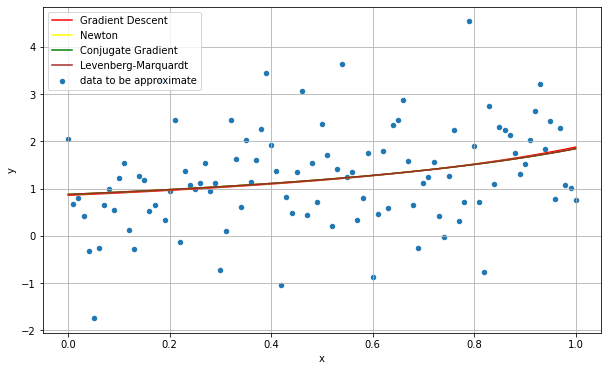

In [114]:
GD_r = gradient_descent(rational_apr)
LM_r = Levenberg_Marquardt_method(rational_apr_lm)
N_r = Newton_method(rational_apr)
CG_r = conjugate_gradient(rational_apr)

plt.figure(figsize=(10,6))
plt.scatter(x_k,y_k,label='data to be approximate', s=20)
plt.plot(x_k, [GD_r[0] / (x_k[i] * GD_r[1] + 1) for i in range(101)], label='Gradient Descent', color='red')
plt.plot(x_k, [N_r[0] / (x_k[i] * N_r[1] + 1) for i in range(101)], label='Newton', color='yellow')
plt.plot(x_k, [CG_r[0] / (x_k[i] * CG_r[1] + 1) for i in range(101)], label='Conjugate Gradient', color='green')
plt.plot(x_k, [LM_r[0] / (x_k[i] * LM_r[1] + 1) for i in range(101)], label='Levenberg-Marquardt', color='brown')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: OptimizeWarning: Unknown solver options: xatol
  This is separate from the ipykernel package so we can avoid doing imports until


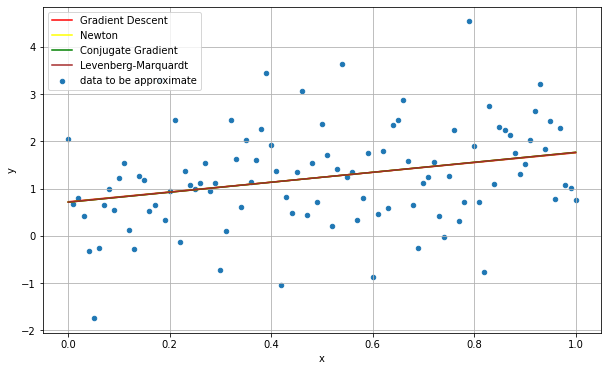

In [115]:
GD_l = gradient_descent(linear_apr)
N_l = Newton_method(linear_apr)
CG_l = conjugate_gradient(linear_apr)
LM_l = Levenberg_Marquardt_method(linear_apr_lm)

plt.figure(figsize=(10,6))
plt.scatter(x_k,y_k,label='data to be approximate', s=20)
plt.plot(x_k, [GD_l[0] * x_k[i] + GD_l[1] for i in range(101)], label='Gradient Descent', color='red')
plt.plot(x_k, [N_l[0] * x_k[i] + N_l[1] for i in range(101)], label='Newton', color='yellow')
plt.plot(x_k, [CG_l[0] * x_k[i] + CG_l[1] for i in range(101)], label='Conjugate Gradient', color='green')
plt.plot(x_k, [LM_l[0] * x_k[i] + LM_l[1] for i in range(101)], label='Levenberg-Marquardt', color='brown')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [116]:
import pandas as pd

In [117]:
# number of iterations
df_iter = pd.DataFrame({'Gradient Descent': [GD_r[3], GD_l[3]], 
                   'Newton': [N_r[3], N_l[3]], 
                   'Conjugate Gradient': [CG_r[3], CG_l[3]], 
                   'Levenberg-Marquardt': [LM_r[3], LM_l[3]]}, index=['rational','linear'])
df_iter

,Gradient Descent,Newton,Conjugate Gradient,Levenberg-Marquardt
rational,7,7,7,4
linear,7,5,3,2


In [118]:
# number of fanction calculations
df_cf = pd.DataFrame({'Gradient Descent': [GD_r[2], GD_l[2]], 
                   'Newton': [N_r[2], N_l[2]], 
                   'Conjugate Gradient': [CG_r[2], CG_l[2]], 
                   'Levenberg-Marquardt': [LM_r[2], LM_l[2]]}, index=['rational','linear'])
df_cf

,Gradient Descent,Newton,Conjugate Gradient,Levenberg-Marquardt
rational,14,8,76,12
linear,14,9,24,6
